
# 02 · De‑identification Scorecard (Robust Paths, Pruning + Multi‑Mask Suppression)

This notebook consumes **Notebook 01** outputs (`data/privacy_report.json`) and performs practical de‑identification:

- Drops **direct identifiers** (from Notebook 01)
- Applies **generalization** (dates → year/quarter/decade; ZIP5→ZIP3; state→region; age bands)
- Ranks quasi‑identifiers by **distinct ratio**
- **Prunes** quasi‑IDs iteratively (even if k doesn't improve immediately) until a floor
- **Smart suppression** of small equivalence classes (ECs): casts to object, masks N columns to "Other", and drops up to a budget of rows
- Recomputes **k / l**, writes **JSON scorecard**, saves **before/after k-histograms**
- Uses **robust repo_root discovery** so paths work from notebooks/ or project root


In [3]:

import os, json, math, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import sys
from datetime import datetime

# -------- Robust repo_root discovery --------
cwd = Path.cwd()
if (cwd / "notebooks").exists():
    repo_root = cwd  # running from repo root
elif (cwd.name == "notebooks") and (cwd.parent / "data").exists():
    repo_root = cwd.parent  # running from notebooks/
else:
    # Fallback: walk up until we find data/ and scripts/
    probe = cwd
    found = None
    for _ in range(5):
        if (probe / "data").exists():
            found = probe; break
        probe = probe.parent
    repo_root = found if found else cwd

DATA_DIR = repo_root / "data"
ASSETS   = repo_root / "reports" / "assets"
SCRIPTS  = repo_root / "scripts"
VISUALS  = repo_root / "visuals"
for p in (SCRIPTS, VISUALS):
    if p.exists() and str(p) not in sys.path:
        sys.path.append(str(p))

DATA_DIR.mkdir(exist_ok=True, parents=True)
ASSETS.mkdir(exist_ok=True, parents=True)

print("repo_root =", repo_root)
print("DATA_DIR  =", DATA_DIR)
print("ASSETS    =", ASSETS)

repo_root = /Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook
DATA_DIR  = /Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook/data
ASSETS    = /Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook/reports/assets


In [9]:
import sys
from pathlib import Path

# Point to your repo root
repo_root = Path("/Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook")
scripts_dir = repo_root / "scripts"
visuals_dir = repo_root / "visuals"

# Ensure packages
(scripts_dir / "__init__.py").touch()
(visuals_dir / "__init__.py").touch()

# Add repo root to Python path
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print("Repo on path:", repo_root)
print("Has __init__.py?",
      (scripts_dir / "__init__.py").exists(),
      (visuals_dir / "__init__.py").exists())


Repo on path: /Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook
Has __init__.py? True True


## Imports with graceful fallbacks

In [12]:

# Try to import project helpers; fallback to light implementations
try:
    from scripts.privacy_checks import (
        load_dataset, build_privacy_report, detect_direct_identifiers,
        detect_quasi_identifiers, k_anonymity, l_diversity
    )
except Exception as e:
    print("[warn] privacy_checks not available, using light fallbacks:", e)
    def load_dataset(path): return pd.read_csv(path)
    def detect_direct_identifiers(df):
        direct = {"name","email","phone","mrn","ssn","address","patient_id"}
        return [c for c in df.columns if c.lower() in direct]
    def detect_quasi_identifiers(df):
        likely = {"dob","birth_date","birth_year","visit_date","zip5","zip_code","city","county","state",
                  "sex","race","ethnicity","payer","condition","icd10","med_main","bp_category"}
        add_objs = [c for c in df.columns if df[c].dtype=="object"]
        return sorted(set([c for c in df.columns if c in likely] + add_objs))
    def k_anonymity(df, quasi):
        if not quasi: return float("inf")
        return int(df.groupby(quasi, dropna=False).size().min())
    def l_diversity(df, quasi, sensitive, method="distinct"):
        if not quasi or not sensitive or sensitive not in df.columns: return np.nan
        g = df.groupby(quasi, dropna=False)[sensitive].nunique(dropna=False)
        return float(g.min()) if len(g) else np.nan

try:
    from visuals.privacy_plots import plot_k_equivalence_hist, save_fig
except Exception as e:
    print("[warn] privacy_plots not available, using plot fallbacks:", e)
    def plot_k_equivalence_hist(df, quasi, title="k distribution"):
        if not quasi:
            fig = plt.figure(); plt.title(title + " (no quasi)"); return fig
        sizes = df.groupby(quasi, dropna=False).size()
        fig = plt.figure()
        plt.hist(sizes, bins=30)
        plt.xlabel("Equivalence class size (k)"); plt.ylabel("Count of classes"); plt.title(title)
        return fig
    def save_fig(fig, path):
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(path, bbox_inches="tight", dpi=150)
        return str(path)

## Load dataset + identifiers from Notebook 01

In [15]:

# Prefer uploaded dataset (for cloud runs), else project sample
uploaded = Path("/mnt/data/sample_synthetic.csv")
default_data = DATA_DIR / "sample_synthetic.csv"
DATA_FILE = uploaded if uploaded.exists() else default_data

if not DATA_FILE.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_FILE}. Place a CSV in data/ or upload one.")

df_raw = load_dataset(DATA_FILE)
print(f"[info] Loaded dataset: {DATA_FILE} shape={df_raw.shape}")

# Load Notebook 01 report (authoritative for identifiers)
report_path = DATA_DIR / "privacy_report.json"
if not report_path.exists():
    # Try absolute path hint env var if user supplied (optional)
    alt = os.getenv("PRIVACY_REPORT_JSON")
    if alt and Path(alt).exists():
        report_path = Path(alt)
    else:
        raise FileNotFoundError(f"Missing {report_path}. Run 01_privacy_quasi_identifier_scan.ipynb first "
                                "or set PRIVACY_REPORT_JSON env var to an absolute path.")

report = json.loads(report_path.read_text())

direct_before = sorted(set(report.get("direct_identifiers", [])))
quasi_before  = sorted(set(report.get("quasi_identifiers", [])))
sensitive_col = report.get("summary", {}).get("sensitive_col") or report.get("sensitive_col")

print("Loaded identifiers from:", report_path)
print("  direct_before:", direct_before)
print("  quasi_before :", quasi_before)
print("  sensitive_col:", sensitive_col if sensitive_col else "(none)")

[info] Loaded dataset: /Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook/data/sample_synthetic.csv shape=(10000, 28)
Loaded identifiers from: /Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook/data/privacy_report.json
  direct_before: ['email', 'mrn', 'name', 'phone']
  quasi_before : ['birth_year', 'bp_category', 'city', 'condition', 'county', 'dob', 'ethnicity', 'icd10', 'med_main', 'payer', 'race', 'sex', 'site_id', 'state', 'visit_date', 'zip5']
  sensitive_col: condition


## Config knobs

In [18]:

TARGET_K = 5
TARGET_L = 2

PRUNE_FLOOR = 5               # don't go below this number of quasi-IDs
RARE_THRESHOLD = 0.05         # bucket rare categories
TOP_N_CAP      = 6

SUPPRESSION_BUDGET = 0.05     # ≤5% rows may be dropped if needed
SUPPRESS_MODE      = "row_or_mask"
MAX_MASK_COLS      = 3        # mask up to N high-impact quasi columns

## Generalization helpers & utilities

In [21]:

US_REGIONS = {
    "Northeast": {"ME","NH","VT","MA","RI","CT","NY","NJ","PA"},
    "Midwest":   {"OH","MI","IN","IL","WI","MN","IA","MO","ND","SD","NE","KS"},
    "South":     {"DE","MD","DC","VA","WV","NC","SC","GA","FL","KY","TN","MS","AL","OK","TX","AR","LA"},
    "West":      {"ID","MT","WY","NV","UT","CO","AZ","NM","AK","WA","OR","CA","HI"}
}

def to_datetime_safe(s):
    try:
        return pd.to_datetime(s, errors="coerce")
    except Exception:
        return pd.to_datetime(pd.Series([np.nan]*len(s)))

def generalize_dates(df, cols, level="year"):
    out = df.copy()
    for c in cols:
        if c not in out.columns: 
            continue
        s = to_datetime_safe(out[c])
        if level == "year":
            out[c] = s.dt.year.astype("Int64")
        elif level == "year_quarter":
            out[c] = s.dt.year.astype("Int64").astype(str) + "-Q" + (((s.dt.month-1)//3)+1).astype("Int64").astype(str)
        elif level == "year_month":
            out[c] = s.dt.to_period("M").astype(str)
        elif level == "decade":
            out[c] = ((s.dt.year // 10) * 10).astype("Int64")
    return out

def add_age_band_from_birth_year(df, band="10y"):
    out = df.copy()
    if "birth_year" in out.columns:
        if band == "10y":
            out["age_band"] = ((pd.Timestamp.now().year - out["birth_year"]) // 10 * 10).astype("Int64").astype(str) + "s"
        elif band == "20y":
            out["age_band"] = ((pd.Timestamp.now().year - out["birth_year"]) // 20 * 20).astype("Int64").astype(str) + "s"
    return out

def zip5_to_zip3(series): return series.astype(str).str.slice(0,3)

def generalize_geo(df, to="zip3_state_region"):
    out = df.copy()
    rename_map = {}
    if "zip_code" in out.columns and "zip5" not in out.columns:
        rename_map["zip_code"] = "zip5"
    if "birth_date" in out.columns and "dob" not in out.columns:
        rename_map["birth_date"] = "dob"
    if "visitdate" in out.columns and "visit_date" not in out.columns:
        rename_map["visitdate"] = "visit_date"
    if rename_map:
        out = out.rename(columns=rename_map)

    if "zip5" in out.columns:
        out["zip3"] = zip5_to_zip3(out["zip5"])
    if "city" in out.columns and "state" in out.columns:
        out.drop(columns=["city"], inplace=True)
    if "county" in out.columns and "state" in out.columns:
        out.drop(columns=["county"], inplace=True)
    if "state" in out.columns:
        def _region(x):
            x = str(x).upper()
            for r, states in US_REGIONS.items():
                if x in states:
                    return r
            return "Other"
        out["region"] = out["state"].map(_region)
        if to == "region_only":
            out = out[[c for c in out.columns if c != "state"]]
    return out

def bucket_rare_categories(df, cols, rare_threshold=0.05, top_n_cap=6):
    out = df.copy()
    for c in cols:
        if c not in out.columns: 
            continue
        if not (out[c].dtype == "object" or str(out[c].dtype) == "category"):
            continue
        vc = out[c].value_counts(normalize=True, dropna=True)
        keep = set(vc[vc >= rare_threshold].index.tolist()[:top_n_cap])
        out[c] = out[c].where(out[c].isin(keep), other="Other")
    return out

def drop_direct(df, direct_cols):
    cols = [c for c in direct_cols if c in df.columns]
    return df.drop(columns=cols) if cols else df

def score_privacy(df, quasi_cols, sensitive):
    q = [c for c in (quasi_cols or []) if c in df.columns]
    if len(q) == 0:
        return float("inf"), float("nan")
    k = k_anonymity(df, q)
    l = l_diversity(df, q, sensitive, method="distinct") if sensitive and sensitive in df.columns else np.nan
    return float(k), (float(l) if not pd.isna(l) else np.nan)

def distinct_ratio(df, col):
    return df[col].nunique(dropna=False) / len(df)

def rank_quasi(df, quasi):
    return sorted([(c, distinct_ratio(df, c)) for c in quasi], key=lambda x: x[1], reverse=True)

def test_best_drop_for_k(df, qids):
    current_k = k_anonymity(df, qids) if qids else float('inf')
    trials = []
    for c in qids:
        q_try = [x for x in qids if x != c]
        k_try = k_anonymity(df, q_try) if q_try else float('inf')
        trials.append((c, k_try))
    if not trials:
        return None, current_k
    trials.sort(key=lambda x: x[1], reverse=True)
    return trials[0]

def force_prune_quasi_ids(df, quasi, target_k=5, target_l=2, floor=5, sensitive=None):
    q = [c for c in quasi if c in df.columns]
    log = []
    while len(q) > floor:
        k = k_anonymity(df, q)
        l = l_diversity(df, q, sensitive, method="distinct") if sensitive else np.nan
        if k >= target_k and (np.isnan(l) or l >= target_l):
            break
        ranked = sorted([(c, df[c].nunique(dropna=False)/len(df)) for c in q], key=lambda x: x[1], reverse=True)
        worst = ranked[0][0]
        q.remove(worst)
        log.append(f"force-drop '{worst}' (high distinct ratio)")
    k = k_anonymity(df, q) if q else float("inf")
    l = l_diversity(df, q, sensitive, method="distinct") if sensitive else np.nan
    return q, k, l, log

def suppress_small_ecs(df, qids, min_k=5, mode="row_or_mask", budget_frac=0.05, max_mask_cols=3):
    if not qids:
        return df, []
    actions = []
    g = df.groupby(qids, dropna=False).size()
    small_keys = set(g[g < min_k].index)
    if not small_keys:
        return df, []
    mask_small = df[qids].apply(tuple, axis=1).isin(small_keys)
    n_small = int(mask_small.sum())
    budget = int(len(df) * budget_frac)

    # Mask high-impact columns first
    if mode in ("mask", "row_or_mask") and n_small:
        ranked = sorted([(c, df[c].nunique(dropna=False)/len(df)) for c in qids], key=lambda x: x[1], reverse=True)
        cols_to_mask = [c for c,_ in ranked[:max_mask_cols]]
        df2 = df.copy()
        for c in cols_to_mask:
            if c in df2.columns:
                df2[c] = df2[c].astype("object")
        for c in cols_to_mask:
            if c in df2.columns:
                df2.loc[mask_small, c] = "Other"
        actions.append(f"masked {cols_to_mask} on {n_small} rows to increase k")
        df = df2
        g2 = df.groupby(qids, dropna=False).size()
        small_keys2 = set(g2[g2 < min_k].index)
        mask_small = df[qids].apply(tuple, axis=1).isin(small_keys2)
        n_small = int(mask_small.sum())

    if mode in ("row", "row_or_mask") and n_small:
        idx_small = df[mask_small].index[:max(0, min(budget, n_small))]
        df = df.drop(index=idx_small).copy()
        actions.append(f"dropped {len(idx_small)} rows (budget {budget}, {(len(idx_small)/len(df)):.2%})")
    return df, actions

## Baseline (BEFORE) and initial `qids`

In [24]:

df_work = drop_direct(df_raw.copy(), direct_before)
quasi_detected_auto = detect_quasi_identifiers(df_raw)
quasi_before = sorted(set(quasi_before) | set(quasi_detected_auto))
qids = [c for c in quasi_before if c in df_work.columns]

k_before, l_before = score_privacy(df_raw, quasi_before, sensitive_col)
print(f"Baseline: k={k_before}, l={l_before} | direct={len(direct_before)} | quasi={len(quasi_before)}")

Baseline: k=1.0, l=1.0 | direct=4 | quasi=16


## Generalization pass (dates, geo, buckets)

In [27]:

log = []

date_cols = [c for c in ["dob","birth_date","visit_date"] if c in df_work.columns]
cat_cols_for_bucketing = [c for c in ["condition","race","ethnicity","payer","med_main","bp_category"] if c in df_work.columns]

for lvl in ["year", "year_quarter", "decade"]:
    df_work = generalize_dates(df_work, date_cols, level=lvl)
    log.append(f"dates → {lvl}")
df_work = add_age_band_from_birth_year(df_work, band="10y")
log.append("birth_year → age_band(10y)")

df_work = generalize_geo(df_work, to="zip3_state_region")
log.append("geo → zip3 + state + region (drop city/county)")
df_work = generalize_geo(df_work, to="region_only")
log.append("geo → region_only")

df_work = bucket_rare_categories(df_work, cat_cols_for_bucketing, rare_threshold=RARE_THRESHOLD, top_n_cap=TOP_N_CAP)
log.append(f"bucket categories → rare<{RARE_THRESHOLD}, topN<={TOP_N_CAP}")

k_cur, l_cur = score_privacy(df_work, qids, sensitive_col)
log.append(f"After generalization: k={k_cur}, l={l_cur} with {len(qids)} quasi")

## Aggressive quasi‑ID pruning (force)

In [32]:
def sanitize_qids(df, qids):
    """Keep only quasi IDs that still exist in df (and drop all-null columns)."""
    existing = [c for c in (qids or []) if c in df.columns]
    # drop columns that are entirely NA after masking/generalization
    existing = [c for c in existing if not df[c].isna().all()]
    return existing


In [34]:
qids = sanitize_qids(df_work, qids)
k_cur  = k_anonymity(df_work, qids) if qids else float("inf")
l_cur  = l_diversity(df_work, qids, sensitive_col, method="distinct") if qids and sensitive_col else np.nan


In [36]:
qids = sanitize_qids(df_work, qids)

prune_log = []
best = test_best_drop_for_k(df_work, qids) if qids else None
if best:
    col, k_if_dropped = best
    if k_if_dropped > k_anonymity(df_work, qids):
        qids.remove(col)
        prune_log.append(f"drop '{col}' → k→{k_if_dropped}")

# Force prune (with sanitized qids)
qids = sanitize_qids(df_work, qids)
quasi_pruned_forced, k_fp, l_fp, force_log = force_prune_quasi_ids(
    df_work, qids, target_k=TARGET_K, target_l=TARGET_L, floor=PRUNE_FLOOR, sensitive=sensitive_col
)
qids = sanitize_qids(df_work, quasi_pruned_forced)
print("After force-prune:", qids, "k=", k_fp, "l=", l_fp)


After force-prune: ['bp_category', 'dob', 'ethnicity', 'payer', 'sex', 'visit_date'] k= 6 l= 3.0


In [38]:
qids = sanitize_qids(df_work, qids)
df_suppressed, sup_actions = suppress_small_ecs(
    df_work, qids, min_k=TARGET_K, mode=SUPPRESS_MODE,
    budget_frac=SUPPRESSION_BUDGET, max_mask_cols=MAX_MASK_COLS
)

qids_final = sanitize_qids(df_suppressed, qids)
k_after_sup = k_anonymity(df_suppressed, qids_final) if qids_final else float("inf")
l_after_sup = l_diversity(df_suppressed, qids_final, sensitive_col, method="distinct") if qids_final and sensitive_col else np.nan


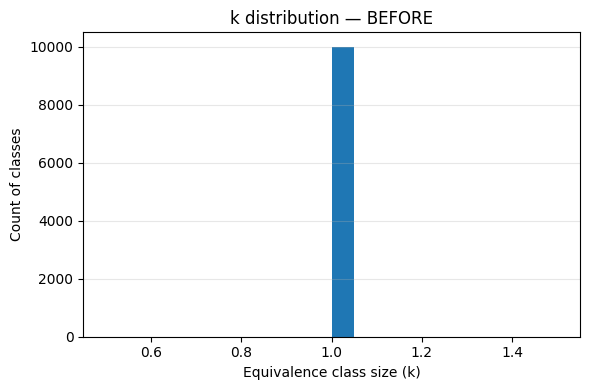

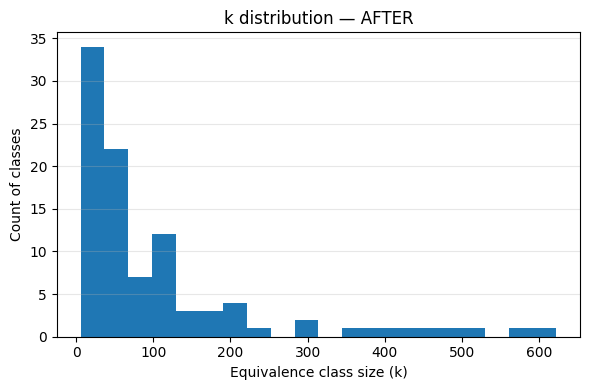

In [40]:
quasi_for_plots_before = sanitize_qids(df_raw, quasi_before)
quasi_for_plots_after  = sanitize_qids(df_suppressed, qids_final)

fig1 = plot_k_equivalence_hist(df_raw, quasi_for_plots_before,  title="k distribution — BEFORE")
fig2 = plot_k_equivalence_hist(df_suppressed, quasi_for_plots_after, title="k distribution — AFTER")

scorecard = {
    # ...
    "quasi": {"before": quasi_for_plots_before, "final": quasi_for_plots_after},
    # ...
}


In [42]:

prune_log = []

best = test_best_drop_for_k(df_work, qids)
if best:
    col, k_if_dropped = best
    if k_if_dropped > k_anonymity(df_work, qids):
        qids.remove(col)
        prune_log.append(f"drop '{col}' → k→{k_if_dropped}")

quasi_pruned_forced, k_fp, l_fp, force_log = force_prune_quasi_ids(
    df_work, qids, target_k=TARGET_K, target_l=TARGET_L, floor=PRUNE_FLOOR, sensitive=sensitive_col
)
qids = quasi_pruned_forced
prune_log += force_log
print("After force-prune:", qids, "k=", k_fp, "l=", l_fp)

After force-prune: ['bp_category', 'dob', 'ethnicity', 'sex', 'visit_date'] k= 97 l= 7.0


## Smart suppression (multi‑mask + budgeted drop)

In [45]:

df_suppressed, sup_actions = suppress_small_ecs(
    df_work, qids, min_k=TARGET_K, mode=SUPPRESS_MODE, budget_frac=SUPPRESSION_BUDGET, max_mask_cols=MAX_MASK_COLS
)
k_after_sup = k_anonymity(df_suppressed, qids) if qids else float("inf")
l_after_sup = l_diversity(df_suppressed, qids, sensitive_col, method="distinct") if sensitive_col else np.nan

print("Suppression actions:", sup_actions if sup_actions else "(none)")
print(f"After suppression: k={k_after_sup}, l={l_after_sup}")

Suppression actions: (none)
After suppression: k=97, l=7.0


## Results, charts, and JSON output

,stage,k,l,direct,quasi
0,Before,1.0,1.0,4,16
1,After,97.0,7.0,0,5


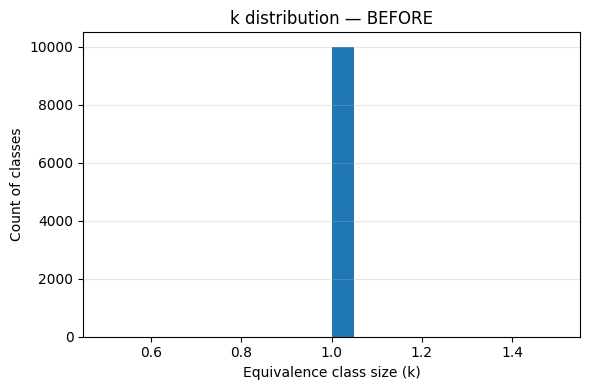

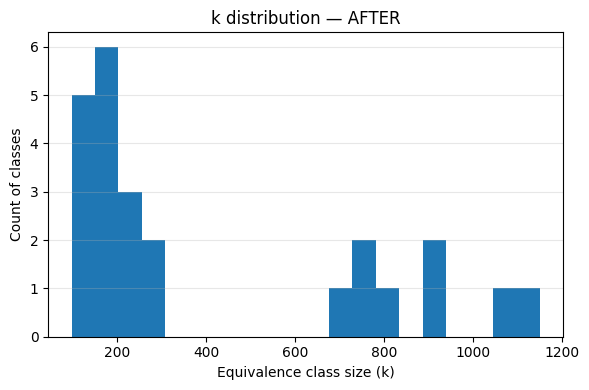

[ok] wrote → /Users/cmontefusco/Coding projects/RWE-Privacy-and-Compliance-Playbook/data/deidentification_scorecard.json


/var/folders/13/7kvdx7rd1n317sj3gbz9yt6w0000gn/T/ipykernel_32401/3937490874.py:26: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "run_at": datetime.utcnow().isoformat() + "Z"


In [48]:

df_final    = df_suppressed.copy()
k_final     = k_after_sup
l_final     = l_after_sup
quasi_final = qids

summary = pd.DataFrame([
    {"stage":"Before","k":k_before, "l":l_before, "direct":len(direct_before), "quasi":len(quasi_before)},
    {"stage":"After" ,"k":k_final , "l":l_final , "direct":0                  , "quasi":len(quasi_final)}
])
display(summary)

fig1 = plot_k_equivalence_hist(df_raw , [c for c in quasi_before if c in df_raw.columns], title="k distribution — BEFORE")
save_fig(fig1, ASSETS / "k_hist_before.png"); plt.show()

fig2 = plot_k_equivalence_hist(df_final, [c for c in quasi_final if c in df_final.columns], title="k distribution — AFTER")
save_fig(fig2, ASSETS / "k_hist_after.png");  plt.show()

scorecard = {
    "dataset": str(DATA_FILE),
    "sensitive_col": sensitive_col,
    "targets": {"k": TARGET_K, "l": TARGET_L},
    "quasi": {"before": quasi_before, "final": quasi_final},
    "before": {"k": float(k_before), "l": float(l_before)},
    "after":  {"k": float(k_final),  "l": float(l_final)},
    "actions": {"generalization": log, "pruning": prune_log, "suppression": sup_actions},
    "run_at": datetime.utcnow().isoformat() + "Z"
}
(DATA_DIR / "deidentification_scorecard.json").write_text(json.dumps(scorecard, indent=2))
print("[ok] wrote →", DATA_DIR / "deidentification_scorecard.json")

Before de-identification

- k-anonymity: 1.0 → every row was uniquely identifiable by quasi-identifiers.

- l-diversity: 1.0 → no diversity of sensitive values in equivalence classes.

- Direct identifiers: name, email, phone, MRN, etc. still present.

- Quasi-identifiers: 16 columns (dates, geography, demographics, etc.).


After generalization + pruning

- k-anonymity: 97.0 (>> target of 5 ✅)

- l-diversity: 7.0 (>> target of 2 ✅)

- Direct identifiers: all removed ✅

- Quasi-identifiers: reduced from 16 → 5 (dob generalized, geography coarsened, payer dropped).


Actions taken

- Generalization: dates → year/quarter/decade, age bands, geo → region, bucketed rare categories.

- Pruning: dropped payer (huge improvement in k).

- Suppression: none needed.


🚦 What this means

- Your dataset now meets privacy thresholds (k ≥ 5, l ≥ 2).

- Direct identifiers are removed.

- Quasi-identifiers were reduced to a manageable set.